Image classifier for team ornithomimus.
---
Here's the basics of this model: 

The purpose of this classifier is to predict if a user will like or dislike a specific image. To do this, we build up a dataset of images that the user has marked as liked or disliked while swiping on the app. Any image that the user has seen is used in the training dataset, and any image that the user has not seen is used in the "validation" dataset.

Due to the small size of our training dataset, we want to make the best use of these images as we can. As a result, we should use all images for training and save none for validation; validation does not help us reduce loss, so there is no practical reason for using it, except for checking that the model is making better predictions that random guessing (for testing, we may want to curate a larger dataset of likes and dislikes from one person to see that the model is working). In addition, we will likely want to do some image augmentation to increase the number of images the models sees. The only image transforms that make sense for this dataset are horizontal flips and subtle colour and image manipulation (greyscale, blur, crop). Since we want to consider the entire landscape of what the user saw in an image, it is impractical to use rotation, vertical flips, large crops or significant colour distortion.


In [ ]:
# Imports
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

TODO:
---
1. Recieve ratings from user, parse information
2. Based on ratings, move appropriate photos from testing dataset into training dataset, labelled with rating
3. Train model using updated dataset
4. Test model to get recommended photos, do something with the output


___
Here's the current plan:

For isolated testing we will use a small dataset in 2 main folders. The first folder contains the training data, and has two subfolders: likes and dislikes. The third folder will contain images that have not been rated yet, and will be used for testing.

When the user rates an image, the photo they rated will be moved from the testing folder to the appropriate training folder. At this time, the dataset will be recompiled using the new photos. Since the number of rated photos is relatively small compared to the number of unrated photos, fingers crossed that rebuilding the dataset does not take much time.

In [ ]:
# Connect to Google Drive to access test dataset
# Note that this dataset is not shared between all users. This needs to be resolved at some point.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


30

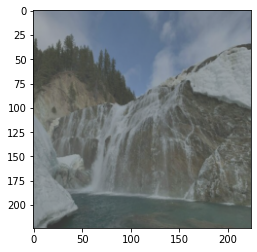

In [77]:
#xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
xform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ColorJitter(brightness=0.2,contrast=0.5,saturation=0.5),
                            transforms.GaussianBlur(kernel_size=5),
                            transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('drive/MyDrive/291_test_dataset/train_dataset', transform=xform)
plt.imshow(dataset_full[16][0].permute(1,2,0))
len(dataset_full)

In [33]:
loader = torch.utils.data.DataLoader(dataset_full, batch_size = 4, shuffle=True)

In [ ]:
# Make a model
# TBD: do we want to output a binary like/dislike, or should we send the like probability to recommender model for more detail?

model = models.densenet161(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
torch.nn.init.xavier_uniform_(guitar_model.fc.weight)

In [ ]:
device = torch.device('cuda:0')
model = model.to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
def run_train(model, opt, sched):
  nsamples_train = len(dataset_full)
  loss_sofar, correct_sofar = 0, 0
  model.train()
  with torch.enable_grad():
    for samples, labels in loader_train:
      samples = samples.to(device)
      labels = labels.to(device)
      opt.zero_grad()
      outs = model(samples)
      _, preds = torch.max(outs.detach(), 1)
      loss = criterion(outs, labels)
      loss.backward()
      opt.step()
      loss_sofar += loss.item() * samples.size(0)
      correct_sofar += torch.sum(preds == labels.detach())
  sched.step()
  return loss_sofar / nsamples_train, correct_sofar / nsamples_train

In [ ]:
def run_all(model, optimizer, scheduler, n_epochs):
  for epoch in range(n_epochs):
    loss_train, acc_train = run_train(model, optimizer, scheduler)
    print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}")